# Image Captioning
- Using Flickr8k Dataset
- Using InceptionV3 for feature extraction

In [1]:
% matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
# Import Keras
from keras.layers import Dense, Embedding, Input, GRU
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img, img_to_array, array_to_img
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer


Using TensorFlow backend.


## Load Dataset (Image and Caption)

10 data loaded successfully
Data Example:


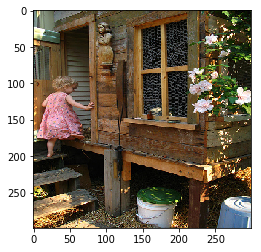

A child in a pink dress is climbing up a set of stairs in an entry way .


In [2]:
def load_dataset(file_path, img_size=(299, 299)):
    X = []
    y = []
    count = 0
    with open(file_path+"/Flickr8k_text/Flickr8k.token.txt") as f:
        for line in f:
            try:
                splitted_line = line.split("#")
                file_name = splitted_line[0]
                y.append(splitted_line[-1][2:].split("\n")[0])
                X.append(img_to_array(load_img(file_path+"/Flickr8k_Dataset/"+file_name, target_size=img_size)))
                count += 1
            except:
                continue
            if count >= 10: # remove this if block if you want to load all images
                break
    return X, y


X, y = load_dataset("datasets/flickr8k/")
print(str(len(y)) + " data loaded successfully")

print("Data Example:")
plt.imshow(array_to_img(X[0]))
plt.show()
print(y[0])

## Build Model

### Build InceptionV3 and Sequence Model with Word Embedding and 3 layers GRU

In [3]:
def build_model(vocab_size):
    inception_v3 = InceptionV3(include_top=False, weights='imagenet', pooling='max')
    for layer in inception_v3.layers:
        layer.trainable = False

    # dense_input = inception_v3.output

    image_dense = Dense(512, activation='tanh', name='image_dense')(inception_v3.output)

    decoder_input = Input(shape=(None,), name='decoder_input')

    net = decoder_input
    net = Embedding(input_dim=vocab_size+1, output_dim=128, name='decoder_embedding')(net)

    net = GRU(512, name='decoder_gru1', return_sequences=True)(net, initial_state=image_dense)
    net = GRU(512, name='decoder_gru2', return_sequences=True)(net, initial_state=image_dense)
    net = GRU(512, name='decoder_gru3', return_sequences=True)(net, initial_state=image_dense)

    decoder_output = Dense(vocab_size+1, activation='linear', name='decoder_output')(net)

    decoder_model = Model([inception_v3.input, decoder_input],
                          outputs=[decoder_output])

    decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
    decoder_model.compile(optimizer="adam",
                          loss=sparse_cross_entropy,
                          target_tensors=[decoder_target])

    return decoder_model

## Loss Function

In [4]:
def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    loss_mean = tf.reduce_mean(loss)

    return loss_mean

## Tokenizer

### Mark the Captions

In [5]:
start_mark = "<start> "
end_mark = " <end>"

def mark_captions(captions):
    marked_captions = [start_mark + caption + end_mark
                       for caption in captions]
    return marked_captions
marked_captions = mark_captions(y)
marked_captions[:5]


['<start> A child in a pink dress is climbing up a set of stairs in an entry way . <end>',
 '<start> A girl going into a wooden building . <end>',
 '<start> A little girl climbing into a wooden playhouse . <end>',
 '<start> A little girl climbing the stairs to her playhouse . <end>',
 '<start> A little girl in a pink dress going into a wooden cabin . <end>']

### Build Sequence

In [6]:
tokenizer = Tokenizer(num_words=1000, filters=".")
tokenizer.fit_on_texts(marked_captions)
text_seqeunces = tokenizer.texts_to_sequences(marked_captions)

padded_sequences = pad_sequences(text_seqeunces,
                                 maxlen=30,
                                 padding="post",
                                 truncating="post")

print(padded_sequences.shape)
input_sequence = padded_sequences[:, 0:-1]
output_sequence = padded_sequences[:, 1:]

print(input_sequence[0])
print(output_sequence[0])

token_start = tokenizer.word_index["<start> ".strip()]
token_end = tokenizer.word_index[" <end>".strip()]
print(token_start, token_end)

(10, 30)
[ 2  1 29  5  1 17 18 30 10 31  1 32 19 20  5 33 34 35  3  0  0  0  0  0
  0  0  0  0  0]
[ 1 29  5  1 17 18 30 10 31  1 32 19 20  5 33 34 35  3  0  0  0  0  0  0
  0  0  0  0  0]
2 3


## Train the Model

In [13]:
model = build_model(len(tokenizer.word_counts))
model.fit([X, input_sequence], output_sequence, epochs=10, batch_size=32, shuffle=True)

# model.save("decoder_model.h5")

Epoch 1/10


10/10 [==============================] - 9s 918ms/step - loss: 4.0478


Epoch 2/10


10/10 [==============================] - 3s 335ms/step - loss: 3.8542


Epoch 3/10


## Predict Image Caption

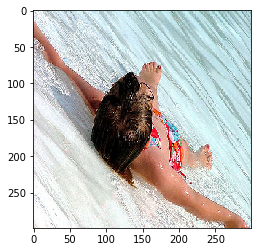

Predicted caption:
 a is is a a a a in



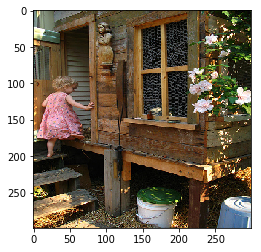

Predicted caption:
 a is is a a a a in



In [ ]:
def generate_caption(image_path, max_tokens=30):
    image = load_img(image_path, target_size=(299, 299))
    image_arr = img_to_array(image)

    image_batch = np.expand_dims(image_arr, axis=0)

    # transfer_values = model.predict(image_batch)

    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    token_int = token_start

    output_text = ''    

    count_tokens = 0
    # print(image_batch)
    word_list = list(tokenizer.word_counts.keys())
    while token_int != token_end and count_tokens < max_tokens:
        decoder_input_data[0, count_tokens] = token_int

        x_data = {'input_2': image_batch,
                  'decoder_input': decoder_input_data}

        decoder_output = model.predict(x_data)

        token_onehot = decoder_output[0, count_tokens, :]

        token_int = np.argmax(token_onehot)

        output_text += " " + word_list[token_int]

        count_tokens += 1

    # output_tokens = decoder_input_data[0]

    plt.imshow(image)
    plt.show()

    print("Predicted caption:")
    print(output_text)
    print()


generate_caption("datasets/flickr8k/Flickr8k_Dataset/667626_18933d713e.jpg")
generate_caption("datasets/flickr8k/Flickr8k_Dataset/1000268201_693b08cb0e.jpg")


In [17]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, None, None, 3 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, None, None, 3 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_95 (Activation)      (None, None, None, 3 0           batch_normalization_95[0][0]     
__________________________________________________________________________________________________
conv2d_96 